In [1]:
import sys
sys.path.append(r'~\Desktop\Programmazione\Github\tum-adlr-11')


import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import torch
from PIL import Image
from dataset.preprocessing import sample_pixels, segmap_to_binary, binary_to_image
import torchvision.transforms as transforms

# Import the UNet class
from model.my_unet_model import UNet
from visualization.view_result import ray_shooting


In [2]:
# Specify the device
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'

# Load the model and map it to the GPU
model = torch.load("model_full.pth", map_location=device)

# Set the model to evaluation mode
model.eval()

print("Model loaded onto", device)

Model loaded onto cpu


C:\Users\iacop\AppData\Local\Temp\ipykernel_15440\3389642070.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("model_full.pth", map_location=device)


In [3]:
def number_to_border( x, length, height):
    if x <= length:
        return (0, x)  #Top border
    elif x <= length + height:
        return (x - length, length - 1)  # Right border
    elif x <= 2 * length + height:
        return (height - 1, 2 * length + height - x)  # Bottom border
    else:
        return (2 * (length + height) - x, 0)  # Left border

torch.Size([1, 1, 224, 224])


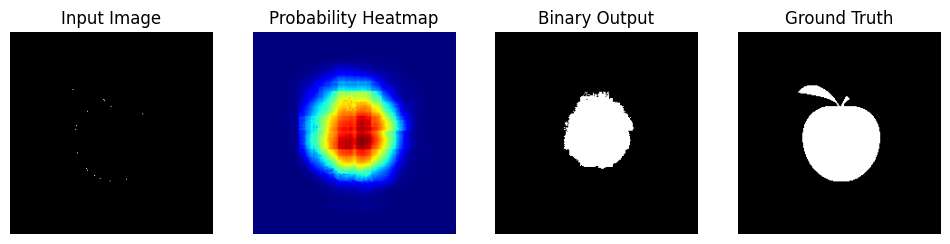

Loss: 0.11454654484987259


In [4]:
# Load the test image
image_path = r"./data/samples/119/0.png"
image = Image.open(image_path).convert('L')
image = np.array(image)
target_image_path = r"./data/119.png"
target_image = Image.open(target_image_path).convert('L')
target_image = np.array(target_image)
input = transforms.ToTensor()(image).unsqueeze(0).to(device)



# Assuming the model is defined and loaded
model.eval()  # Set the model to evaluation mode (disables dropout, batch norm updates)
with torch.no_grad():  # Disable gradient calculation for evaluation
    y = model(input)  # Get the model's predictions

print(y.shape)

y_image = y[0][0].cpu().numpy()
binary_output = (y_image > 0.5).astype(np.uint8)
#show image, probability heatmap and ground truth
plt.figure(figsize=(12, 6))
plt.subplot(1, 4, 1)
plt.imshow(image, cmap='gray')
plt.title('Input Image')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(y_image, cmap='jet')
plt.title('Probability Heatmap')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(binary_output, cmap='gray')
plt.title('Binary Output')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(target_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')
plt.show()

#Calculate loss
loss = torch.nn.BCELoss()
target = transforms.ToTensor()(target_image).unsqueeze(0).to(device)
loss_value = loss(y, target)
print('Loss:', loss_value.item())




Length and height = 224 224
Selected Border Point (x, y): [122, 0]
Ray Shooting Angle: 90 degrees
Ray Shooting Result: (x, y) = (122, 71)
Angle for Ray: 90 degrees
<built-in method sum of numpy.ndarray object at 0x000002C549914A50>
Output Image Shape: (224, 224)
Binary Mask Shape: (224, 224)


C:\Users\iacop\AppData\Local\Temp\ipykernel_15440\783826495.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='lower right')


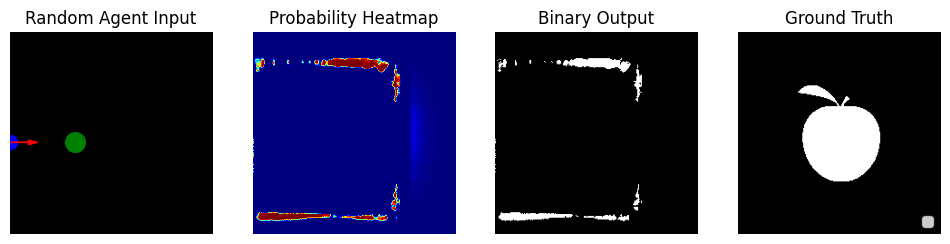

In [ ]:
from visualization.view_result import ray_shooting
import numpy as np
import torch
import matplotlib.pyplot as plt

# Random agent simulation
# Assuming `target_image` is a numpy array or similar object
length, height = target_image.shape  # .shape is an attribute, not a method
print("Length and height =", length, height)

# Example border point and angle
border = [122, 0]  # Border point
angle = 90  # Angle in degrees

print(f"Selected Border Point (x, y): {border}")
print(f"Ray Shooting Angle: {angle} degrees")

# Perform ray shooting
x, y = ray_shooting(border, angle, length, height, target_image)
print(f"Ray Shooting Result: (x, y) = ({x}, {y})")
print(f"Angle for Ray: {angle} degrees")

# Create a black image
image_black = np.zeros((length, height), dtype=np.uint8)  # Values from 0 to 255
if x is not None and y is not None:
    image_black[x][y] = 255

print(np.sum(image_black))
# Convert input array to a tensor suitable for the model
input_tensor = torch.tensor(image_black, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
input_tensor = input_tensor.unsqueeze(1)  # Add channel dimension

# Evaluate the model
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for evaluation
    output = model(input_tensor)  # Get the model's predictions

# Convert the model output to a probability map and binary mask
output_image = output[0][0].cpu().numpy()  # Get the first output channel as a numpy array
binary_output = (output_image > 0.5).astype(np.uint8)  # Thresholding to create a binary mask

# Print shape of the output image and binary output for clarity
print(f"Output Image Shape: {output_image.shape}")
print(f"Binary Mask Shape: {binary_output.shape}")

# Visualization using Matplotlib
plt.figure(figsize=(12, 6))

# Input visualization
plt.subplot(1, 4, 1)
plt.imshow(image_black, cmap='gray')
plt.title('Random Agent Input')
plt.axis('off')

# Add a blue dot for the border point
plt.scatter(border[1], border[0], color='blue', s=100, label='Border Point')  # Adjust s for dot size

# Add an arrow for the angle
arrow_length = 20  # Adjust the length of the arrow
arrow_dx = arrow_length * np.cos(np.radians(angle))  # Calculate arrow x component
arrow_dy = arrow_length * np.sin(np.radians(angle))  # Calculate arrow y component
plt.arrow(border[1], border[0], arrow_dy, arrow_dx, head_width=5, head_length=10, fc='red', ec='red', label='Angle')

# Highlight the found point
if x is not None and y is not None:
    plt.scatter(y, x, color='green', s=200, label='Found Point')  # Larger marker for found point

# Probability heatmap
plt.subplot(1, 4, 2)
plt.imshow(output_image, cmap='jet')
plt.title('Probability Heatmap')
plt.axis('off')

# Binary output visualization
plt.subplot(1, 4, 3)
plt.imshow(binary_output, cmap='gray')
plt.title('Binary Output')
plt.axis('off')

# Ground truth visualization
plt.subplot(1, 4, 4)
plt.imshow(target_image, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

# Display the plots
plt.legend(loc='lower right')
plt.show()
